In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.decomposition import PCA
from ipdb import set_trace as st
import matplotlib.animation as animation
import itertools

##

In [2]:
# with toy dataset

n_samples = 200
# rng = np.random.RandomState(0)
# idxs = np.arange(n_samples)
# rng.shuffle(idxs)

# todo: X_all to X
X_all, y_all = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=0)
# , cluster_std=[1.2, 1.6]

# create a boolean mask to unlabel most of the data
mask_seed = np.array([False] * len(y_all))
mask_seed[-8:] = True
mask = mask_seed.copy()

def plot_X_y(X, y, **kwargs):
    """Plot each category as a different color, `kwargs` provide formatting options"""
    for i in range(len(set(y))):
        ax.scatter(X[y==i, 0], X[y==i, 1], color=f'C{i}', **kwargs)


##

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
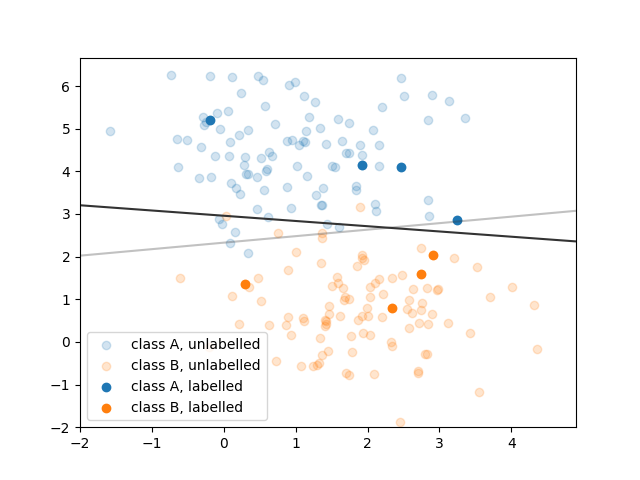

In [3]:

# fit a logistic regression to all of the data
clf_all = LogisticRegression(random_state=0)
clf_all.fit(X_all, y_all)

# fit a logistic regression to the labelled data only
clf = LogisticRegression(random_state=0)
clf.fit(X_all[mask], y_all[mask])

# create a grid for the decision boundary plot
xx, yy = np.mgrid[-2:5:.1, -2:5:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
probs_all = clf_all.predict_proba(grid)[:, 1].reshape(xx.shape)


fig, ax = plt.subplots()
plot_X_y(X_all, y_all, alpha=0.2)
plot_X_y(X_all[mask], y_all[mask])
ax.contour(xx, yy, probs_all, levels=[.5], cmap="Greys", alpha=0.3, vmin=0, vmax=.6)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.legend(['class A, unlabelled', 'class B, unlabelled', 'class A, labelled', 'class B, labelled'])

# find the unlabelled point that is closest to the decision boundary
idx2 = np.argmin(abs(clf.decision_function(X_all[~mask])))
# get the index in the original `X_all` array
idx = np.where(X_all== X_all[~mask][idx2])[0][0]
# "label" this new datum
mask[idx] = True


##

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
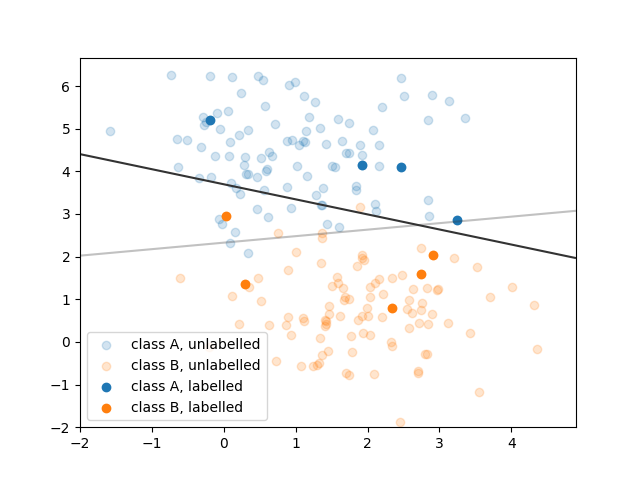

In [4]:

clf.fit(X_all[mask], y_all[mask])

probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

fig, ax = plt.subplots()
plot_X_y(X_all, y_all, alpha=0.2)
plot_X_y(X_all[mask], y_all[mask])
ax.contour(xx, yy, probs_all, levels=[.5], cmap="Greys", alpha=0.3, vmin=0, vmax=.6)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.legend(['class A, unlabelled', 'class B, unlabelled', 'class A, labelled', 'class B, labelled'])


##

In [5]:


class Active_ml():
    """Combine the classifier model and the iteration state in a class."""
    def __init__(self, mask_seed, n_iters=30):
        self.mask = mask_seed.copy()  # starting labelled target data
        self.n_iters = n_iters  # number of frames in gif
        self.idx = None  # index of the last labelled point
        self.iter_cnt = 0  # iteration counter
        self.clf = LogisticRegression(random_state=0).fit(X_all[self.mask], y_all[self.mask])
        # for plotting decision boundary of all data
        clf_all = LogisticRegression(random_state=0).fit(X_all, y_all)
        self.probs_all = clf_all.predict_proba(grid)[:, 1].reshape(xx.shape)

    def plot_X_y(self, ax, X, y, **kwargs):
        """Plot each category as a different color, `kwargs` provide formatting options"""
        lines = []
        for i in range(len(set(y))):
            l = ax.scatter(X[y == i, 0], X[y == i, 1], color=f'C{i}', **kwargs)
            lines.append(l)

        # return list of artists for gif
        return lines

    def refit(self):
        """Re-run the model with the new labelled data."""
        # find the unlabelled point that is closest to the decision boundary
        idx2 = np.argmin(abs(self.clf.decision_function(X_all[~self.mask])))
        # np.argmin(abs(self.clf.decision_function(X_all[~self.mask])))
        # self.clf.decision_function(X_all[~self.mask])
        # get the index in the original `X_all` array
        idx = np.where(X_all == X_all[~self.mask][idx2])[0][0]
        # "label" this new datum
        self.mask[idx] = True
        # update iteration counter
        self.iter_cnt += 1
        # refit the model
        self.clf.fit(X_all[self.mask], y_all[self.mask])


    def replot(self, ax=None):
        """Plot updated model with new labelled data."""
        # if needed, create a new figure
        if not ax:
            fig, ax = plt.subplots(figsize=(15, 10))

        l1 = self.plot_X_y(ax, X_all, y_all, alpha=0.2)
        l2 = ax.contour(xx, yy, probs_all, levels=[.5], cmap="Greys", alpha=0.3, vmin=0, vmax=.6)
        l3 = self.plot_X_y(ax, X_all[self.mask], y_all[self.mask])
        probs = self.clf.predict_proba(grid)[:, 1].reshape(xx.shape)
        l4 = ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

        # import ipdb; ipdb.set_trace()
        return list(itertools.chain(l1, l2.collections, l3, l4.collections))
        # return list(itertools.chain(l1, l2))

    def iterate(self):
        self.refit()
        lines = self.replot()

    def make_gif(self, ax):
        """Make the animation"""
        frames = []
        for n in range(self.n_iters):
            self.refit()
            artists = self.replot(ax)
            frames.append(artists)

        return frames


##

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
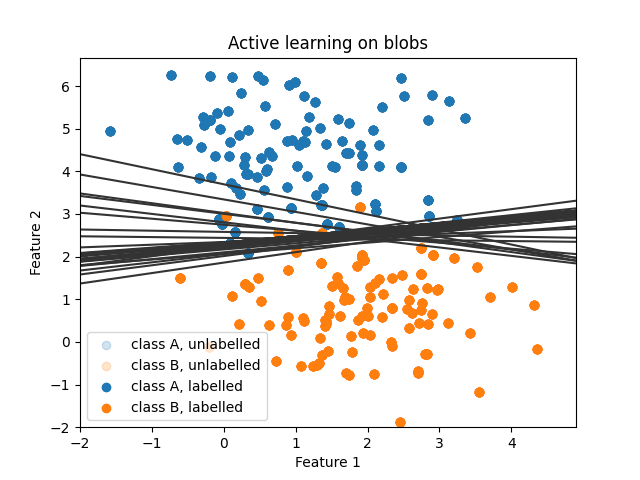

In [6]:

aml = Active_ml(mask_seed, n_iters=30)

fig, ax = plt.subplots()
frames = aml.make_gif(ax)

# figure formatting
ax.set_title('Active learning on blobs')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(['class A, unlabelled', 'class B, unlabelled', 'class A, labelled', 'class B, labelled'])

ani = animation.ArtistAnimation(fig, frames, blit=True, interval=500, repeat_delay=200)